 # Week 11: Exercise 11.2
 File: DSC530_Paulovici_Exercise_11.2.py (.ipynb)<br>
 Name: Kevin Paulovici<br>
 Date: 11/10/2019<br>
 Course: DSC 530 Data Exploration and Analysis<br>
 Assignment: Chapter 13: 13.1

In [1]:
import pandas as pd
import numpy as np

import thinkplot
import thinkstats2
import survival


 ## Chapter 13

 ### Exercise 12.1
 In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

 Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

 Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

 Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [2]:
# read in respondent data from NSFG Cycle 6 and 7
df_6 = survival.ReadFemResp2002()
df_7 = survival.ReadFemResp2010()

df_6.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives
0,2298,902,False,NaN,NaN,4,5556.717241,1234,NaN,27.666667,75,7,15
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11
3,6794,1042,False,NaN,NaN,0,5923.977368,1234,NaN,16.000000,86,8,17
4,616,991,False,NaN,NaN,0,7229.128072,1233,NaN,20.166667,82,8,16


In [3]:
# function to clean up / add data to dataframes
def cleandf(df):
    """

    @param: df (dataframe) - df of NSFG cycle
    """
    df.cmdivorcx.replace([998, 9999], np.nan, inplace=True)

    # set the columns for not divorced, duration, and duration so far
    df['notdivorced'] = df.cmdivorcx.isnull().astype(int)
    df['duration'] = (df.cmdivorcx - df.cmmarrhx) / 12.0
    df['durationsofar'] = (df.cmintvw - df.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in df.cmbirth]
    df['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10


In [4]:
# clean data
cleandf(df_6)
cleandf(df_7)

# get the married subset data
hitched_6 = df_6[df_6.evrmarry == 1]
hitched_7 = df_7[df_7.evrmarry == 1]

hitched_6.head()


,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,8.583333,21.583333
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,2.333333,27.000000
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,24.750000
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,19.500000
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,23.333333


In [5]:
# create functions for survival by resampling groupped by decases

def EstSurvival(df):
    """ Survival curve estimate

    @param: df - dataframe of respondent data

    return:
    @param: hf - hazard function
    @param: sf - hazard function
    """
    sad = df[df.notdivorced == 0].duration.dropna()
    happy = df[df.notdivorced == 1].duration.dropna() # married

    hf = survival.EstimateHazardFunction(sad, happy)
    sf = hf.MakeSurvival()

    return hf, sf

def EstSurvivalDecade(groups, **opt):
    """ plot survival curves by decades

    @param: groups - decade grouped object
    """
    thinkplot.PrePlot(len(groups))

    for _, group in groups:
        _, sf = EstSurvival(group)
        thinkplot.Plot(sf, **opt)

def DivorceCurveDecade(dfs):
    """ plot divorce curves 

    @param: dfs - list of dataframes (hitched_)
    """
    for i in range(50):
        samples = [thinkstats2.ResampleRowsWeighted(df) for df in dfs]
        sample = pd.concat(samples, ignore_index = True, sort=True)
        groups = sample.groupby('decade')

        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.5)
        
        EstSurvivalDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years', ylabel='Fraction undivorced', axis=[0, 28, 0, 1])


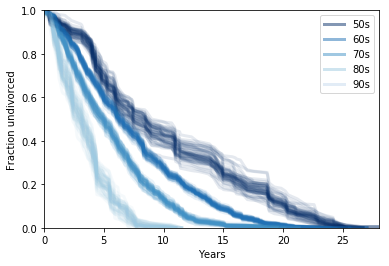

In [6]:
# plot the data
DivorceCurveDecade([hitched_6, hitched_7])
